In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/from_pyupbit/bitcoin.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,value
0,2018-10-15 22:34:00,7465000.0,7469000.0,7464000.0,7467000.0,3.273223,2.443834e+07
1,2018-10-15 22:35:00,7467000.0,7467000.0,7460000.0,7460000.0,7.458447,5.565499e+07
2,2018-10-15 22:36:00,7462000.0,7464000.0,7459000.0,7460000.0,4.706309,3.511643e+07
3,2018-10-15 22:37:00,7459000.0,7465000.0,7457000.0,7457000.0,9.961767,7.430318e+07
4,2018-10-15 22:38:00,7457000.0,7464000.0,7457000.0,7462000.0,1.454620,1.085506e+07
...,...,...,...,...,...,...,...
3125995,2024-10-10 20:14:00,82881000.0,82881000.0,82880000.0,82881000.0,0.239679,1.986479e+07
3125996,2024-10-10 20:15:00,82881000.0,82881000.0,82847000.0,82881000.0,0.402308,3.333924e+07
3125997,2024-10-10 20:16:00,82881000.0,82881000.0,82847000.0,82881000.0,0.331244,2.744975e+07
3125998,2024-10-10 20:17:00,82876000.0,82881000.0,82848000.0,82881000.0,0.163958,1.358785e+07


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [6]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2018-10-15 22:34:00,7465000.0,7469000.0,7464000.0,7467000.0,3.273223,2.443834e+07
2018-10-15 22:35:00,7467000.0,7467000.0,7460000.0,7460000.0,7.458447,5.565499e+07
2018-10-15 22:36:00,7462000.0,7464000.0,7459000.0,7460000.0,4.706309,3.511643e+07
2018-10-15 22:37:00,7459000.0,7465000.0,7457000.0,7457000.0,9.961767,7.430318e+07
2018-10-15 22:38:00,7457000.0,7464000.0,7457000.0,7462000.0,1.454620,1.085506e+07
...,...,...,...,...,...,...
2024-10-10 20:14:00,82881000.0,82881000.0,82880000.0,82881000.0,0.239679,1.986479e+07
2024-10-10 20:15:00,82881000.0,82881000.0,82847000.0,82881000.0,0.402308,3.333924e+07
2024-10-10 20:16:00,82881000.0,82881000.0,82847000.0,82881000.0,0.331244,2.744975e+07


In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, 'models/bitcoin_scaler.pkl')

['models/bitcoin_scaler.pkl']

In [8]:
timestep = 1

In [9]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [10]:
X, y = np.array(X), np.array(y)

In [11]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [17]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
78150/78150 [==============================] - 139s 2ms/step - loss: 3.1805e-05 - val_loss: 7.0323e-06
Epoch 2/20
78150/78150 [==============================] - 138s 2ms/step - loss: 6.3050e-07 - val_loss: 5.1374e-07
Epoch 3/20
78150/78150 [==============================] - 139s 2ms/step - loss: 5.0636e-07 - val_loss: 6.5682e-07
Epoch 4/20
78150/78150 [==============================] - 141s 2ms/step - loss: 4.4545e-07 - val_loss: 8.2659e-06
Epoch 5/20
78150/78150 [==============================] - 139s 2ms/step - loss: 4.0396e-07 - val_loss: 3.6173e-06
Epoch 6/20
78150/78150 [==============================] - 138s 2ms/step - loss: 3.7414e-07 - val_loss: 2.5520e-06
Epoch 7/20
78150/78150 [==============================] - 137s 2ms/step - loss: 3.5632e-07 - val_loss: 2.8525e-06
Epoch 8/20
78150/78150 [==============================] - 141s 2ms/step - loss: 3.4036e-07 - val_loss: 2.2477e-06
Epoch 9/20
78150/78150 [==============================] - 141s 2ms/step - loss: 3.2175e-

In [18]:
model.save('models/lstm_bitcoin.h5')

/Users/sun/anaconda3/envs/dl/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19538/19538 [==============================] - 11s 562us/step


In [20]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [21]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 38535.10
Test RMSE: 105200.17


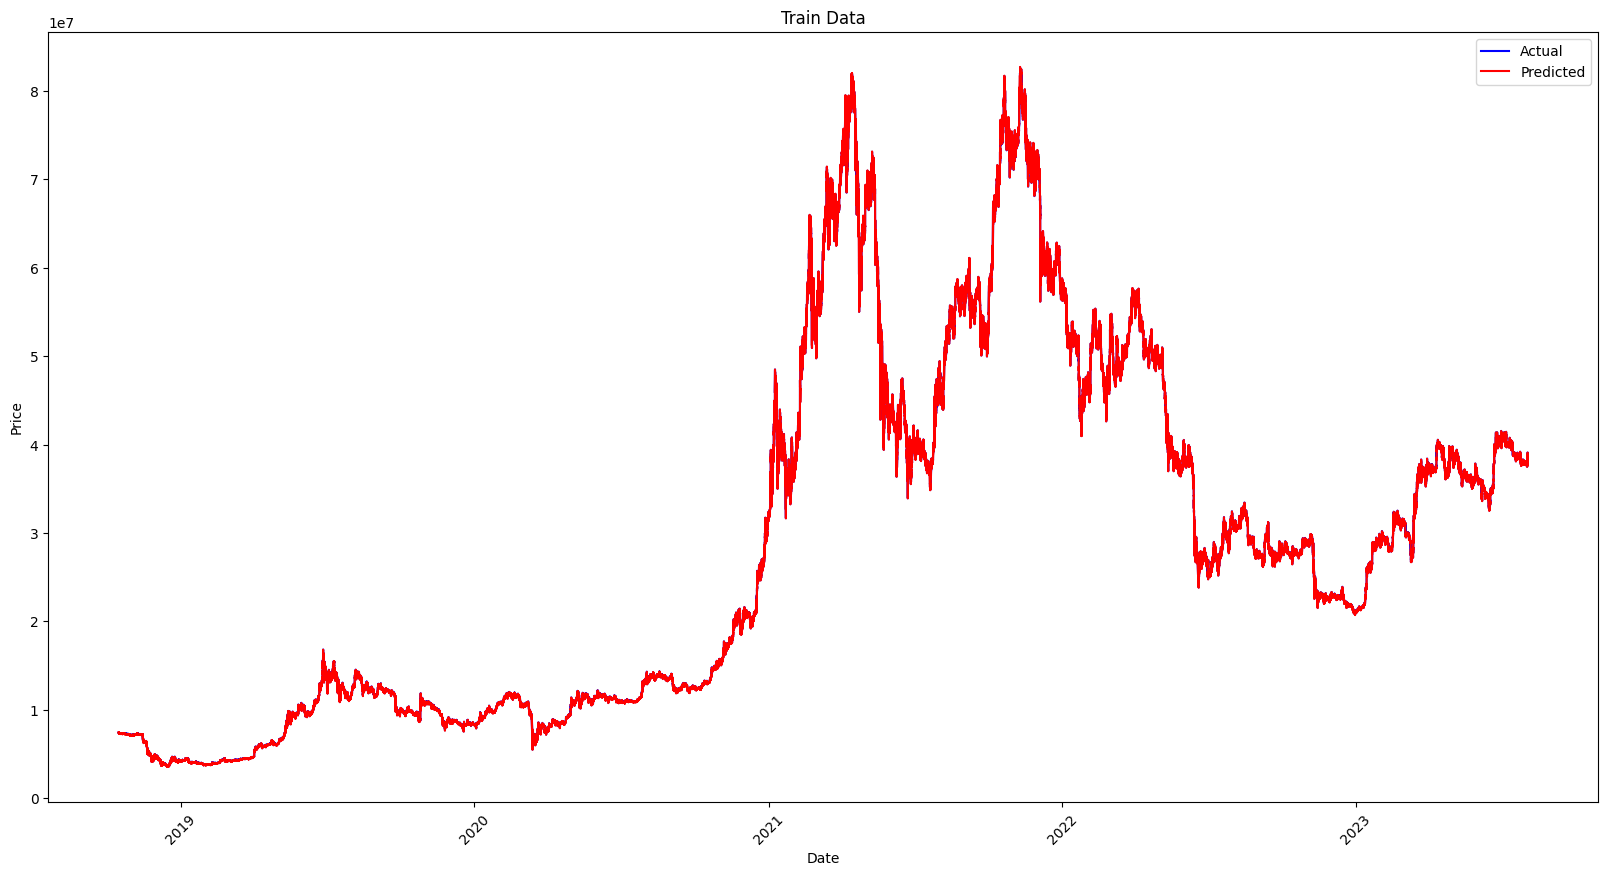

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

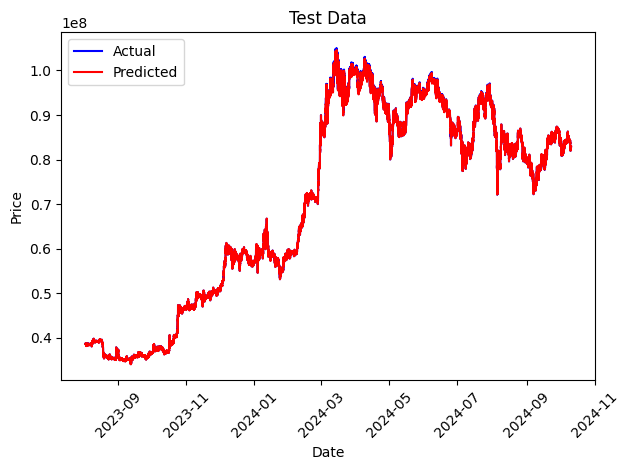

In [23]:
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [24]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.78192931]]


In [25]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 12ms/step
[[82900992.]]


In [22]:
# Predict the future
# future_predictions = []
# for _ in range(len(new_df)):
#     pred = model.predict(X_predict)
#     future_predictions.append(pred[0, 0])
#     pred = pred.reshape(1, 1, 1)
#     X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))